<a href="https://colab.research.google.com/github/noooah2000/learn-pytorch-assignments/blob/main/Custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

In [1]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup the random seed
RANDOM_SEED = 42

2.6.0+cu124


In [3]:
# 取得資料
import requests
import zipfile
from pathlib import Path

data_path = Path('data')
image_path = data_path / 'pizza_steak_sushi'
zip_path = data_path / 'pizza_steak_sushi.zip'

if image_path.is_dir():
  print(f"{image_path} is exists")
else:
  print(f"Creating {image_path} now")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(zip_path, 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
    print('Downloading the zip files of images ...')
    f.write(request.content)

  with zipfile.ZipFile(zip_path, 'r') as zipf:
    print('Unzipping the zip file ... ')
    zipf.extractall(image_path)


Creating data/pizza_steak_sushi now
Unzipping the zip file ... 


In [4]:
# 設定資料路徑
train_dir = image_path / 'train'
test_dir = image_path / 'test'
print(train_dir)
print(test_dir)

data/pizza_steak_sushi/train
data/pizza_steak_sushi/test


Random image path: data/pizza_steak_sushi/train/steak/1598345.jpg
Image class: steak
Image height: 343
Image width: 512


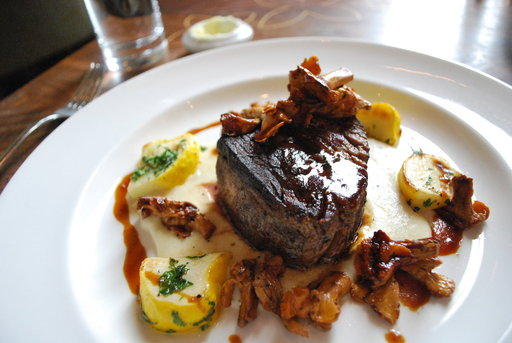

In [5]:
# 印出來看看
import random
from PIL import Image

random.seed(RANDOM_SEED)
image_path_list = list(image_path.rglob("*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


(np.float64(-0.5), np.float64(511.5), np.float64(342.5), np.float64(-0.5))

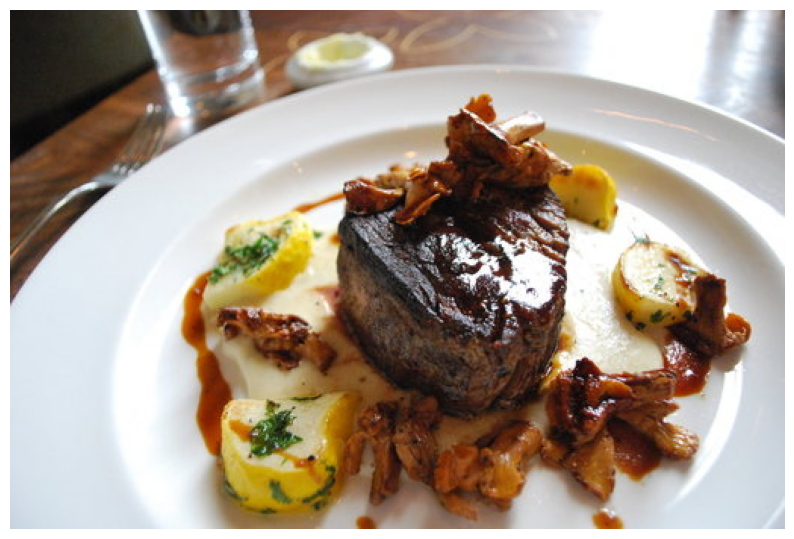

In [6]:
# 用matplotlib印出來
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_array)
plt.axis(False)

In [7]:
# Custom Dataset的helper function
import os

def FindClasses(directory):
  classes = sorted(entry.name for entry in os.scandir(path=directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
  class_to_idx = {class_name:idx for idx, class_name in enumerate(classes)}
  return classes, class_to_idx

FindClasses(test_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [8]:
# 設計Custom Dataset(包含訓練資料的資料擴增設計)
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, target_dir, transform, transform_augment=None, augment=False):
    self.paths = list(target_dir.rglob('*.jpg'))
    self.transform = transform
    self.transform_augment = transform_augment
    self.augment = augment
    self.classes , self.class_to_idx = FindClasses(target_dir)

  def load_image(self, index):
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self):
    return 2*len(self.paths) if self.augment else len(self.paths)

  def __getitem__(self, index):
    if self.augment:
      original_index = index % len(self.paths)
      is_aug = (index >= len(self.paths))
    else:
      original_index = index
      is_aug = False

    class_name = self.paths[original_index].parent.name
    class_index = self.class_to_idx[class_name]
    img = self.load_image(original_index)

    if is_aug:
      return self.transform_augment(img), class_index
    else:
      return self.transform(img), class_index


In [9]:
# 設定資料的transform處裡
import torchvision
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize((224, 224)), ## (224, 224)是由於transfer learning的默認size
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()])

transform_original = transforms.Compose([transforms.Resize((224, 224)),
                                         transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor()])

In [10]:
# 實體化Dataset
train_dataset = CustomDataset(target_dir=train_dir,
                              transform=transform_original,
                              transform_augment=train_transform,
                              augment=True)

test_dataset = CustomDataset(target_dir=test_dir,
                             transform=test_transform)

train_dataset_original = CustomDataset(target_dir=train_dir,
                                       transform=transform_original)
class_names = train_dataset.classes

test_dataset_labels = torch.tensor([test_dataset[i][1] for i in range(len(test_dataset))])
test_dataset_labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

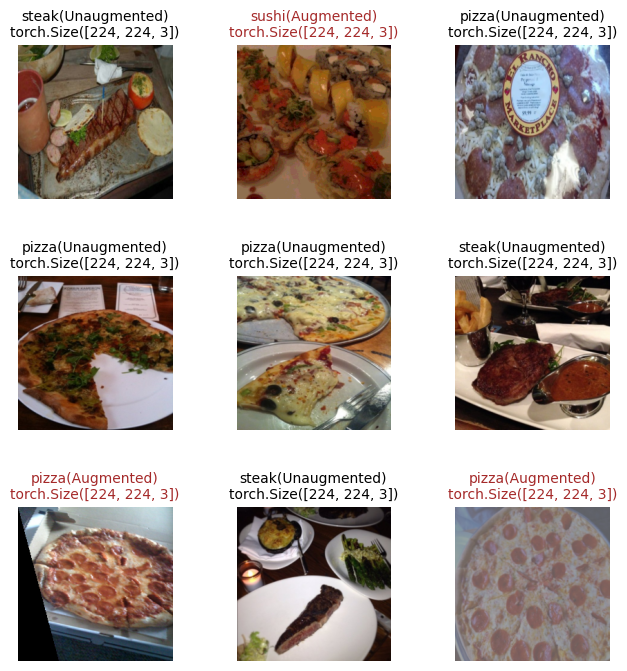

In [11]:
# 視覺化有無augmented的差別
random_idx_list = random.sample(range(len(train_dataset)), k=9)
plt.figure(figsize=(8,8))
for i, idx in enumerate(random_idx_list):
  image, label = train_dataset[idx]
  image = image.permute(1, 2, 0) #imshow()支援pytorch的tensor
  augment_status = idx // (len(train_dataset)/2)
  status = '(Augmented)' if augment_status else '(Unaugmented)'

  plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title(f"{class_names[label]}{status}\n{image.shape}", size=10, c='brown' if augment_status else 'black')
  plt.subplots_adjust(hspace=0.5, wspace=0.2)
  plt.axis(False)

In [12]:
# 設定Dataloader
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

next(iter(train_dataloader))[0].shape


torch.Size([32, 3, 224, 224])

In [13]:
# 設定Transfer Learning的模型
torch.manual_seed(42)
torch.cuda.manual_seed(42)

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.2, inplace=True),
                                       torch.nn.Linear(in_features=1280,
                                                       out_features=len(class_names), bias=True)
                                       ).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s] 


In [14]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_func: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()
  train_loss, train_acc = 0, 0

  for X_train, y_train in tqdm(dataloader, desc='training', leave=False):
    X_train, y_train = X_train.to(device), y_train.to(device)

    y_logits = model(X_train)
    y_labels = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_func(y_logits, y_train)
    train_loss += loss
    acc = (y_labels==y_train).sum().item() / len(y_labels)
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [15]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_func: torch.nn.Module):
  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for X_test, y_test in tqdm(dataloader, desc='testing', leave=False):
      X_test, y_test = X_test.to(device), y_test.to(device)

      y_logits = model(X_test)
      y_labels = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

      loss = loss_func(y_logits, y_test)
      test_loss += loss
      acc = (y_labels==y_test).sum().item() / len(y_labels)
      test_acc += acc

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [16]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_func: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_func=loss_func,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_func=loss_func)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    train_acc, test_acc = train_acc*100, test_acc*100
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f}% | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}%"
    )

  return results

In [17]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

NUM_EPOCHS = 5
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_func=loss_func,
                        epochs=NUM_EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/15 [00:00<?, ?it/s]

testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9814 | train_acc: 50.6250% | test_loss: 0.8304 | test_acc: 72.3485%


training:   0%|          | 0/15 [00:00<?, ?it/s]

testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7082 | train_acc: 79.5833% | test_loss: 0.6043 | test_acc: 87.6894%


training:   0%|          | 0/15 [00:00<?, ?it/s]

testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5865 | train_acc: 86.0417% | test_loss: 0.5323 | test_acc: 87.6894%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79ddd92e45e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers


training:   0%|          | 0/15 [00:00<?, ?it/s]

    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4835 | train_acc: 90.4167% | test_loss: 0.4941 | test_acc: 87.6894%


training:   0%|          | 0/15 [00:00<?, ?it/s]

testing:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.4252 | train_acc: 88.3333% | test_loss: 0.4182 | test_acc: 88.7311%


In [18]:
# 預測函數
def MakePredictions(model, some_sample_in_test_data, device):
  pred_label_list = []
  model.eval()
  with torch.inference_mode():
    for sample in some_sample_in_test_data:
      sample = torch.unsqueeze(sample, dim=0) #因為模型只吃(batch_size,C,H,W)的input，但sample沒有batch這個維度
      pred_logit = model(sample.to(device))
      pred_label = torch.argmax(pred_logit, dim=1)
      pred_label_list.append(pred_label.cpu())
  return torch.cat(pred_label_list) #把list合併成一個tensor

In [19]:
import random
from random import sample, seed
#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=16):
  test_samples.append(sample)
  test_labels.append(label)
test_samples[0].shape ,test_labels

(torch.Size([3, 224, 224]), [2, 1, 2, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 0, 0, 1])

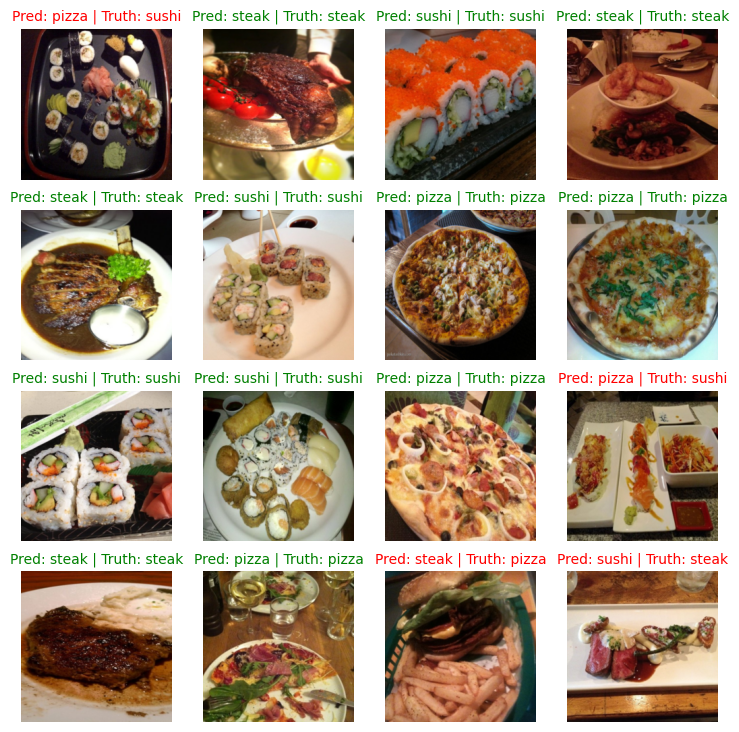

In [20]:
# 視覺化預測結果
pred_labels = MakePredictions(model=model,
                              some_sample_in_test_data=test_samples,
                              device=device)

plt.figure(figsize=(9, 9))
row, col = 4, 4
for idx, sample in enumerate(test_samples):
  plt.subplot(row, col, idx+1)
  plt.imshow(sample.permute(1, 2, 0).numpy())
  pred_label = pred_labels[idx]
  truth_label = test_labels[idx]
  title_text = f"Pred: {class_names[pred_label]} | Truth: {class_names[truth_label]}"
  plt.title(title_text, fontsize=10, c='g' if pred_label == truth_label else 'r')
  plt.axis(False)

In [21]:
# 測試資料預測的結果
model.eval()
with torch.inference_mode():
  y_preds = torch.tensor([], dtype=torch.int32)
  for a_batch_of_X, _ in tqdm(test_dataloader, desc="Making predictions"):
    a_batch_of_y_preds = MakePredictions(model=model,
                            some_sample_in_test_data=a_batch_of_X,
                            device=device)

    y_preds = torch.cat((y_preds, a_batch_of_y_preds), dim=0)
print(y_preds[:100])

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
        1, 2, 2])


In [22]:
try:
  import torchmetrics, mlxtend
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 782.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00
mlxtend version: 0.23.4


Count of correct predictions for class [pizza]: 23
Count of correct predictions for class [steak]: 17
Count of correct predictions for class [sushi]: 28


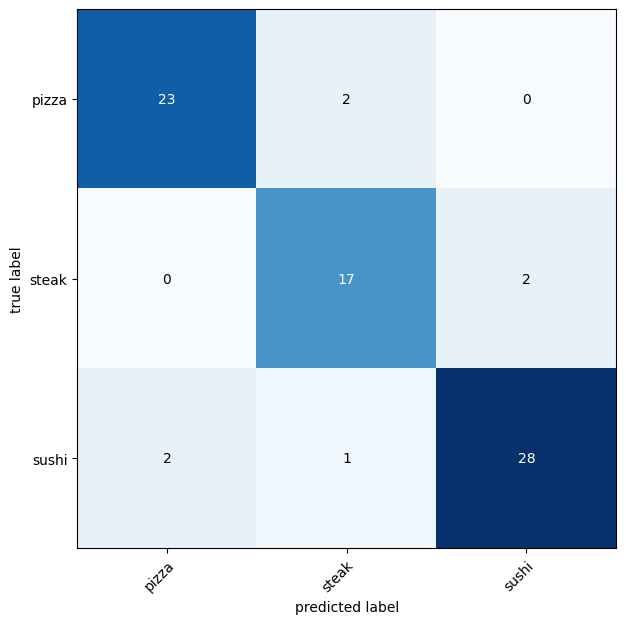

In [23]:
# 用Confusion Matrix分析模型精準度
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names),
                          task='multiclass')
confmat_tensor = confmat(preds=y_preds,
                         target=test_dataset_labels)
plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                      class_names=class_names,
                      figsize=(10, 7))
for idx in range(len(class_names)):
  count = torch.sum((y_preds == idx)&(test_dataset_labels == idx))
  print(f"Count of correct predictions for class [{class_names[idx]}]: {count}")